# IEEE 802.1AS 时间同步实验参数整理（修正版）

## 网络拓扑参数
- **拓扑结构**: 线性链状拓扑，从时钟主节点到最远节点
- **网络规模**: 最大100跳（100个时间感知系统）
- **链路类型**: IEEE 802.3全双工点对点链路
- **数据传输速率**: 100 Mbits/s
- **链路长度**: 实验中使用10米（对应铜线中50ns的传播延迟）

## 时钟参数
- **时钟漂移率初始值范围**: [-10, 10] ppm (每个时钟随机分配)
- **时钟漂移率变化率**: [0, 1] ppm/s
- **时钟粒度**: 8 ns

## 时间感知系统参数
- **PHY抖动范围**: 0-8 ns (均匀分布)
- **最大驻留时间**: 1 ms
- **工作模式**: 同步锁定模式(syncLocked = true)
- **传输模式**: 单步模式(one-step mode)

## IEEE 802.1AS配置参数
- **同步间隔**: 31.25 ms (低于标准默认值125 ms)
- **传播延迟测量间隔**: 1 s
- **邻居频率比率误差上限**: ±0.1 ppm

## 仿真参数
- **单次仿真时长**: 100 s
- **仿真次数**: 100次独立仿真
- **每次仿真随机初始化时钟漂移率**: [-10, 10] ppm
- **传播延迟测量**: 测量值约为62 ns (真实值50 ns + PHY抖动和时钟粒度的影响)
- **传播延迟变化**: ±3 ns

## 同步精度评估方法
- **测量点**: 每次时钟校正前后
- **同步概率定义**: |ti - tGM| < p0 的测量点百分比
- **精度阈值**: 分析了0.2μs, 0.5μs, 0.75μs, 1μs, 1.5μs, 2μs等不同精度阈值

## 实验结果概要
- **100跳节点精度**: 约±2 μs
- **10跳节点精度**: 可达±0.75 μs（从图9可见，在0.75μs阈值时同步概率达到100%）
- **30跳内节点**: 可以实现1μs的同步精度
- **实验覆盖**: 320,000个测试用例

## 总结

论文研究了IEEE 802.1AS在大规模工业自动化网络中的同步质量，特别关注了PHY抖动和时钟粒度等实际实现细节对同步精度的影响。

关键发现包括：

1. **实现细节的重要性**：PHY抖动和时钟粒度显著影响同步精度，这些因素在信息传递过程中累积，使100跳网络的同步精度从理想情况下的0.6μs增加到约2μs。

2. **跳数与精度的关系**：
   - 10跳节点可达到±0.75μs的精度（100%同步概率）
   - 30跳内节点可以实现±1μs的精度
   - 100跳节点可以实现±2μs的精度

3. **IEEE 802.1AS性能**：即使考虑PHY抖动和时钟粒度，IEEE 802.1AS仍能满足其原始要求，即6跳内达到1μs精度。实际上，该协议在更大范围（30跳内）也能满足1μs精度要求。

4. **传播延迟测量**：IEEE 802.1AS测量的传播延迟包含了PHY抖动和时钟粒度的影响，使测量值（62ns）大于实际物理延迟（50ns）。

5. **理论与实际的差异**：最坏情况理论分析预测100跳网络精度为6.925μs，但实际仿真结果约为2μs，这是因为很多情况下误差会相互抵消。

这些参数和发现为在工业自动化环境中实施IEEE 802.1AS提供了宝贵参考，特别是在评估大规模网络的同步性能时。

运行仿真: 100%|██████████| 100/100 [2:05:01<00:00, 75.02s/it] 


仿真完成，结果已保存到output_data_v2和output_image_v2文件夹


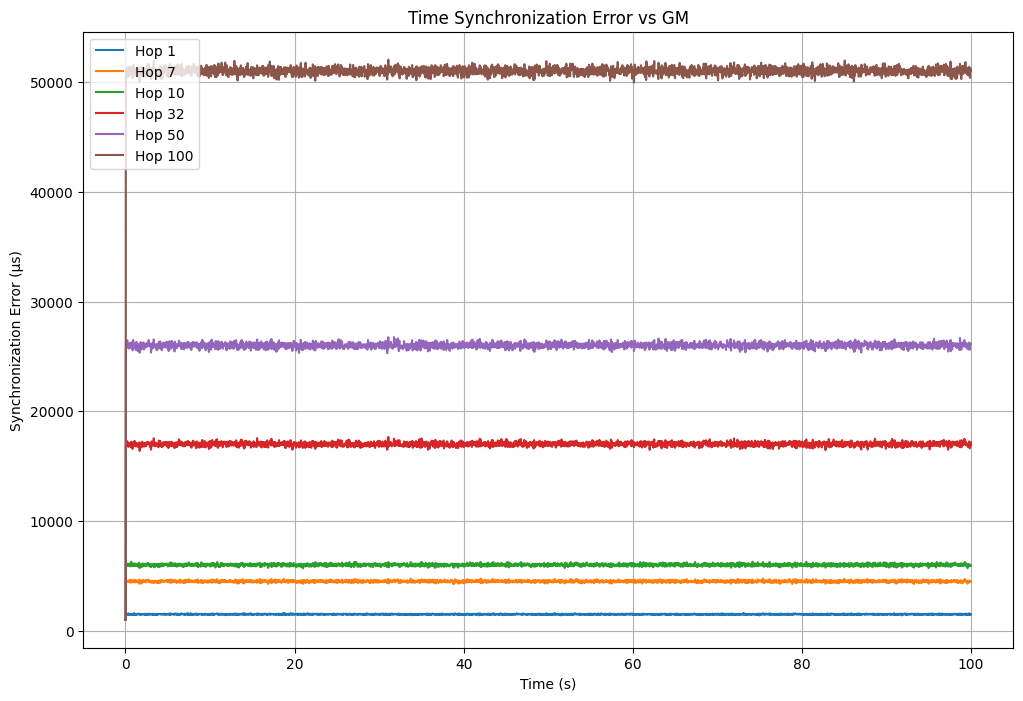

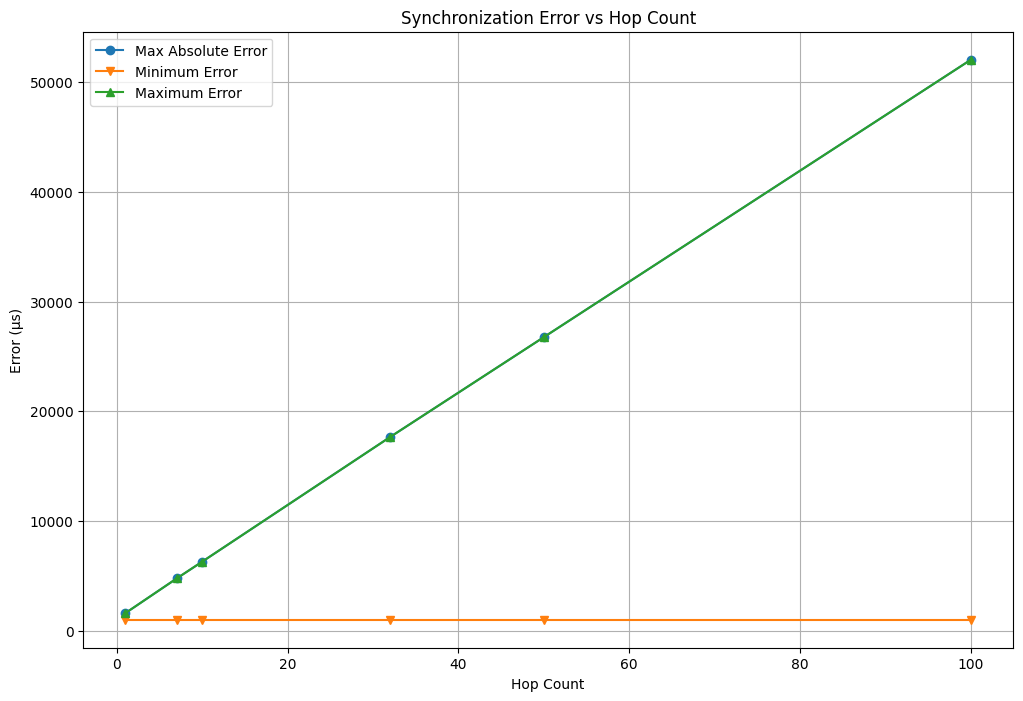

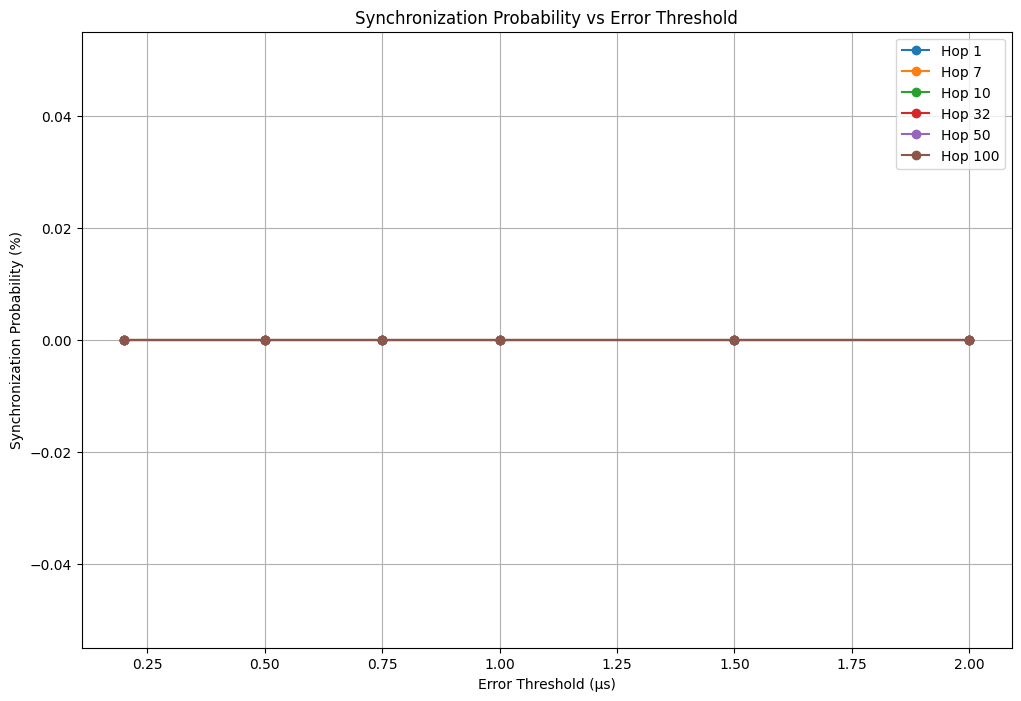

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm
import random
import time

# 确保输出目录存在
os.makedirs("output_data_v2", exist_ok=True)
os.makedirs("output_image_v2", exist_ok=True)

class Clock:
    """时钟类，模拟节点的物理时钟"""
    
    def __init__(self):
        """初始化时钟"""
        self.time = 0
        # 初始漂移率 [-10, 10] ppm
        self.drift_rate = np.random.uniform(-10, 10)
        # 漂移率变化率 [0, 1] ppm/s
        self.drift_rate_change = np.random.uniform(0, 1)
        # 时钟粒度 8 ns
        self.granularity = 8e-9
    
    def update(self, elapsed_time):
        """
        更新时钟，考虑漂移率和粒度
        
        参数:
            elapsed_time: 物理时间流逝，单位秒
        返回:
            更新后的时间
        """
        # 更新漂移率 (考虑随时间的变化)
        drift_change = np.random.normal(0, self.drift_rate_change * elapsed_time)
        self.drift_rate += drift_change
        
        # 计算时间前进量 (考虑漂移率)
        # 漂移率单位是ppm，所以需要乘以1e-6转换
        time_advance = elapsed_time * (1 + self.drift_rate * 1e-6)
        
        # 考虑时钟粒度的影响 (时间只能以时钟粒度为单位增加)
        ticks = np.round(time_advance / self.granularity)
        time_increase = ticks * self.granularity
        
        self.time += time_increase
        return self.time
    
    def get_time(self):
        """获取当前时钟时间"""
        return self.time
    
    def adjust_time(self, offset):
        """
        调整时钟时间
        
        参数:
            offset: 时间偏移量，正值表示向前调整，负值表示向后调整
        """
        # 考虑时钟粒度的影响
        ticks = np.round(offset / self.granularity)
        actual_offset = ticks * self.granularity
        self.time += actual_offset


class TimeAwareSystem:
    """时间感知系统，实现IEEE 802.1AS的功能"""
    
    def __init__(self, node_id, is_gm=False):
        """
        初始化时间感知系统
        
        参数:
            node_id: 节点ID
            is_gm: 是否为主时钟(Grand Master)
        """
        self.node_id = node_id
        self.is_gm = is_gm
        self.clock = Clock()
        self.sync_locked = True  # 同步锁定模式
        self.parent = None
        self.children = []
        
        # IEEE 802.1AS 参数
        self.sync_interval = 31.25e-3  # 同步间隔 31.25 ms
        self.pdelay_interval = 1.0     # 传播延迟测量间隔 1 s
        self.max_freq_error = 0.1e-6   # 邻居频率比率误差上限 ±0.1 ppm
        
        # 时间同步状态
        self.last_sync_time = 0
        self.last_pdelay_time = 0
        self.propagation_delay = 62e-9  # 初始传播延迟估计值
        self.residence_time = 0         # 驻留时间，最大1ms
        
        # 性能指标
        self.time_errors = []
        self.time_stamps = []
    
    def add_child(self, child_node):
        """添加子节点"""
        self.children.append(child_node)
        child_node.parent = self
    
    def get_time(self):
        """获取当前节点的时间"""
        return self.clock.get_time()
    
    def update(self, elapsed_real_time, real_time, gm_time):
        """
        更新节点状态
        
        参数:
            elapsed_real_time: 物理时间流逝
            real_time: 当前物理时间
            gm_time: 主时钟当前时间
        """
        # 更新物理时钟
        self.clock.update(elapsed_real_time)
        
        # 记录与主时钟的误差
        error = self.get_time() - gm_time
        self.time_errors.append(error)
        self.time_stamps.append(real_time)
        
        # 如果是主时钟，无需同步
        if self.is_gm:
            return
        
        # 检查是否需要执行同步
        if real_time - self.last_sync_time >= self.sync_interval:
            # 执行同步
            self.synchronize()
            self.last_sync_time = real_time
        
        # 检查是否需要测量传播延迟
        if real_time - self.last_pdelay_time >= self.pdelay_interval:
            self.measure_propagation_delay()
            self.last_pdelay_time = real_time
    
    def synchronize(self):
        """执行时间同步过程"""
        if not self.parent or not self.sync_locked:
            return
        
        # 获取父节点时间
        parent_time = self.parent.get_time()
        
        # 计算驻留时间 (不超过1ms)
        self.residence_time = np.random.uniform(0, 1e-3)
        
        # 模拟单步同步模式
        # 加上链路延迟和驻留时间
        corrected_time = parent_time + self.propagation_delay + self.residence_time
        
        # 考虑PHY抖动的影响 (0-8 ns均匀分布)
        phy_jitter = np.random.uniform(0, 8e-9)
        corrected_time += phy_jitter
        
        # 计算时间调整量
        current_time = self.get_time()
        time_adjustment = corrected_time - current_time
        
        # 应用时间调整
        self.clock.adjust_time(time_adjustment)
    
    def measure_propagation_delay(self):
        """测量链路传播延迟"""
        if not self.parent:
            return
        
        # 实际传播延迟为50ns
        actual_delay = 50e-9
        
        # PHY抖动 (0-8 ns均匀分布)
        phy_jitter_1 = np.random.uniform(0, 8e-9)
        phy_jitter_2 = np.random.uniform(0, 8e-9)
        
        # 传播延迟变化 (±3 ns)
        delay_variation = np.random.uniform(-3e-9, 3e-9)
        
        # 最终测量的传播延迟 (考虑双向抖动和变化)
        measured_delay = actual_delay + (phy_jitter_1 + phy_jitter_2)/2 + delay_variation
        
        # 由于时钟粒度的影响，延迟会被量化
        measured_delay = np.round(measured_delay / self.clock.granularity) * self.clock.granularity
        
        # 更新传播延迟估计
        self.propagation_delay = measured_delay


class NetworkSimulation:
    """网络仿真类，实现整个网络拓扑和仿真逻辑"""
    
    def __init__(self, num_hops=100):
        """
        初始化网络仿真
        
        参数:
            num_hops: 网络跳数，默认为100
        """
        self.num_hops = num_hops
        self.nodes = []
        self.real_time = 0
        self.simulation_time = 100  # 仿真时长 100 秒
        self.time_step = 0.001      # 时间步长 1 ms
        
        # 创建网络拓扑
        self.create_topology()
    
    def create_topology(self):
        """创建线性链状拓扑"""
        # 创建主时钟节点 (GM)
        gm_node = TimeAwareSystem(0, is_gm=True)
        self.nodes.append(gm_node)
        
        # 创建其他节点，形成链状拓扑
        for i in range(1, self.num_hops + 1):
            node = TimeAwareSystem(i)
            self.nodes.append(node)
            
            # 建立父子关系 (线性链状)
            self.nodes[i-1].add_child(node)
    
    def run_simulation(self):
        """运行一次完整的仿真"""
        # 重置仿真状态
        self.real_time = 0
        
        # 清空所有节点的历史数据
        for node in self.nodes:
            node.time_errors = []
            node.time_stamps = []
        
        # 运行仿真
        steps = int(self.simulation_time / self.time_step)
        for _ in range(steps):
            # 首先获取GM时间
            gm_time = self.nodes[0].get_time()
            
            # 更新所有节点
            for node in self.nodes:
                node.update(self.time_step, self.real_time, gm_time)
            
            # 前进仿真时间
            self.real_time += self.time_step
    
    def collect_results(self):
        """收集仿真结果"""
        results = {}
        for node in self.nodes:
            results[node.node_id] = {
                'time_errors': node.time_errors,
                'time_stamps': node.time_stamps
            }
        return results


def run_multiple_simulations(num_sims=100, num_hops=100):
    """
    运行多次独立仿真
    
    参数:
        num_sims: 仿真次数
        num_hops: 网络跳数
    
    返回:
        all_results: 所有仿真结果
    """
    all_results = []
    
    for sim in tqdm(range(num_sims), desc="运行仿真"):
        # 设置随机种子，确保每次仿真都不同
        np.random.seed(sim)
        random.seed(sim)
        
        # 创建并运行一次仿真
        simulation = NetworkSimulation(num_hops)
        simulation.run_simulation()
        
        # 收集结果
        results = simulation.collect_results()
        all_results.append(results)
        
        # 保存当前仿真结果到CSV
        save_simulation_results(results, sim)
    
    return all_results


def save_simulation_results(results, sim_index):
    """
    保存单次仿真结果到CSV文件
    
    参数:
        results: 仿真结果
        sim_index: 仿真索引
    """
    for node_id, data in results.items():
        # 创建DataFrame
        df = pd.DataFrame({
            'time': data['time_stamps'],
            'error_seconds': data['time_errors'],
            'error_microseconds': [e * 1e6 for e in data['time_errors']]  # 转换为微秒
        })
        
        # 保存到CSV
        filename = f"output_data_v2/node_{node_id}_sim_{sim_index}.csv"
        df.to_csv(filename, index=False)


def analyze_results(all_results, hops_to_analyze=[1, 7, 10, 32, 50, 100]):
    """
    分析多次仿真结果并生成图表
    
    参数:
        all_results: 所有仿真结果
        hops_to_analyze: 需要分析的跳数列表
    """
    # 确保我们只分析存在的跳数
    valid_hops = []
    for hop in hops_to_analyze:
        if hop <= len(all_results[0]) - 1:  # 减1是因为node_id从0开始
            valid_hops.append(hop)
        else:
            print(f"警告: 跳数 {hop} 超出范围，将被忽略")
    
    # 提取每个跳数的时间序列数据 (使用第一次仿真的时间戳)
    time_series = {}
    error_series = {hop: [] for hop in valid_hops}
    
    for hop in valid_hops:
        if hop in all_results[0]:
            time_series[hop] = all_results[0][hop]['time_stamps']
    
    # 对每个仿真结果，提取指定跳数的误差数据
    for sim_results in all_results:
        for hop in valid_hops:
            if hop in sim_results:
                # 提取该次仿真该跳数的误差
                errors = sim_results[hop]['time_errors']
                
                # 如果是第一次添加，直接设置
                if len(error_series[hop]) == 0:
                    error_series[hop] = [errors]
                else:
                    # 否则添加到列表中
                    error_series[hop].append(errors)
    
    # 计算每个时间点的平均误差和标准差
    mean_errors = {}
    std_errors = {}
    
    for hop in valid_hops:
        if hop in error_series and len(error_series[hop]) > 0:
            # 转换为numpy数组以便计算
            error_array = np.array(error_series[hop])
            
            # 计算每个时间点的平均误差和标准差
            mean_errors[hop] = np.mean(error_array, axis=0)
            std_errors[hop] = np.std(error_array, axis=0)
    
    # 绘制时间同步误差折线图
    plt.figure(figsize=(12, 8))
    
    for hop in valid_hops:
        if hop in mean_errors:
            # 转换为微秒
            errors_us = mean_errors[hop] * 1e6
            times = time_series[hop]
            
            # 绘制平均误差
            plt.plot(times, errors_us, label=f'Hop {hop}')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Synchronization Error (μs)')
    plt.title('Time Synchronization Error vs GM')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image_v2/time_sync_error.png', dpi=300)
    
    # 绘制最大误差与跳数的关系
    plt.figure(figsize=(12, 8))
    
    max_abs_errors = []
    min_errors = []
    max_errors = []
    
    for hop in valid_hops:
        if hop in mean_errors:
            # 计算每个跳数的误差统计 (微秒)
            max_abs_error = np.max(np.abs(mean_errors[hop])) * 1e6
            min_error = np.min(mean_errors[hop]) * 1e6
            max_error = np.max(mean_errors[hop]) * 1e6
            
            max_abs_errors.append(max_abs_error)
            min_errors.append(min_error)
            max_errors.append(max_error)
    
    plt.plot(valid_hops, max_abs_errors, 'o-', label='Max Absolute Error')
    plt.plot(valid_hops, min_errors, 'v-', label='Minimum Error')
    plt.plot(valid_hops, max_errors, '^-', label='Maximum Error')
    
    plt.xlabel('Hop Count')
    plt.ylabel('Error (μs)')
    plt.title('Synchronization Error vs Hop Count')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image_v2/error_vs_hop.png', dpi=300)
    
    # 计算不同精度阈值下的同步概率
    thresholds = [0.2, 0.5, 0.75, 1.0, 1.5, 2.0]  # 微秒
    sync_probabilities = {hop: [] for hop in valid_hops}
    
    for hop in valid_hops:
        if hop in mean_errors:
            for threshold in thresholds:
                # 计算误差在阈值内的百分比
                errors_us = np.abs(mean_errors[hop]) * 1e6
                probability = np.mean(errors_us < threshold) * 100
                sync_probabilities[hop].append(probability)
    
    # 绘制同步概率图
    plt.figure(figsize=(12, 8))
    
    for hop in valid_hops:
        if hop in sync_probabilities:
            plt.plot(thresholds, sync_probabilities[hop], 'o-', label=f'Hop {hop}')
    
    plt.xlabel('Error Threshold (μs)')
    plt.ylabel('Synchronization Probability (%)')
    plt.title('Synchronization Probability vs Error Threshold')
    plt.legend()
    plt.grid(True)
    plt.savefig('output_image_v2/sync_probability.png', dpi=300)


if __name__ == "__main__":
    # 运行仿真
    num_simulations = 100
    num_hops = 100
    all_results = run_multiple_simulations(num_simulations, num_hops)
    
    # 分析结果
    analyze_results(all_results, [1, 7, 10, 32, 50, 100])
    
    print("仿真完成，结果已保存到output_data_v2和output_image_v2文件夹")